In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import os
print(os.listdir("./drive/My Drive/cell_images/"))


['Uninfected', 'Parasitized']


In [5]:
img_dir='./drive/My Drive/cell_images/'

In [6]:
transform_train = transforms.Compose([
                                      transforms.RandomResizedCrop(256), #takes random location and resize it and crop it to given size
                                      transforms.ToTensor(), # coverting it to tensor. note the sequence of functions
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
                                      #mean and standard deviation equally to RGB
])
transform_test = transforms.Compose([
                                      transforms.RandomResizedCrop(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [7]:
train_data = torchvision.datasets.ImageFolder(img_dir,transform=transform_train)

In [8]:
print(len(train_data))

27558


In [11]:
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(len(valid_idx), len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=16, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=10, 
    sampler=test_sampler, num_workers=num_workers)

5511 2756 19291


In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([32, 3, 256, 256])
torch.Size([3, 256, 256])
0


In [15]:
num_classes = 2

In [16]:
from torchvision import models

In [17]:
vgg = models.vgg16_bn() 

In [18]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [19]:
#changing the final layer of vgg out_feature as 2 bc we have 2 classes
#we need to update that features itself using this process
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[: -1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=2, bias=True)]


In [20]:
#changing above updated modified classes into main vgg network
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [21]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred==labels).sum().item()
  return 100 * correct/ total

In [48]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

In [49]:
import copy

Min loss 0.30
Iteration: 0/603, Loss: 0.30
Min loss 0.28
Min loss 0.27
Min loss 0.24
Min loss 0.21
Min loss 0.21
Min loss 0.16
Iteration: 100/603, Loss: 0.29
Min loss 0.16
Min loss 0.13
Iteration: 200/603, Loss: 0.50
Iteration: 300/603, Loss: 0.31
Min loss 0.12
Iteration: 400/603, Loss: 0.20
Iteration: 500/603, Loss: 0.28
Min loss 0.12
Iteration: 600/603, Loss: 0.24
Epoch: 0/25, Test acc: 86.97, Train acc: 86.66
Iteration: 0/603, Loss: 0.26
Iteration: 100/603, Loss: 0.42
Iteration: 200/603, Loss: 0.44
Iteration: 300/603, Loss: 0.29
Iteration: 400/603, Loss: 0.24
Iteration: 500/603, Loss: 0.31
Iteration: 600/603, Loss: 0.18
Epoch: 1/25, Test acc: 84.98, Train acc: 86.71
Iteration: 0/603, Loss: 0.29
Min loss 0.07
Iteration: 100/603, Loss: 0.25
Iteration: 200/603, Loss: 0.23
Iteration: 300/603, Loss: 0.19
Iteration: 400/603, Loss: 0.29
Iteration: 500/603, Loss: 0.24
Iteration: 600/603, Loss: 0.39
Epoch: 2/25, Test acc: 87.37, Train acc: 87.51
Iteration: 0/603, Loss: 0.20
Iteration: 100/60

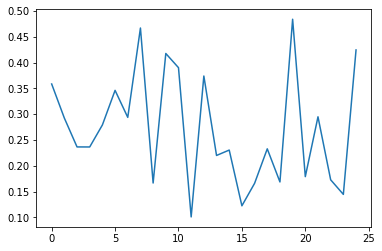

In [50]:
loss_epoch_arr = []
max_epochs = 25

min_loss = 1000

n_iters = len(train_loader)

for epoch in range(max_epochs):

  for i, data in enumerate(train_loader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(vgg.state_dict())
      print('Min loss %0.2f' % min_loss)

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))

    del inputs, labels, outputs
    torch.cuda.empty_cache()

  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
      epoch, max_epochs,
      evaluation(test_loader, vgg), evaluation(train_loader, vgg)
  ))

plt.plot(loss_epoch_arr)
plt.show()

In [51]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(test_loader,vgg), evaluation(train_loader,vgg)))

Test acc: 87.70, Train acc: 88.75


In [52]:
path = "vgg-trained-modelgpu.pth"
torch.save(vgg, path)

In [53]:
vgg = vgg.to('cpu')

In [54]:
from glob import glob
from PIL import Image
from termcolor import colored

In [55]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.5, 0.5, 0.5], 
                                                          [0.5, 0.5, 0.5])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [56]:
class_names=['Parasitized','Uninfected']
img_path = './drive/My Drive/cell_images/Parasitized/C100P61ThinF_IMG_20150918_145042_cell_162.png'
img = load_input_image(img_path)
out = vgg(img)
max_values, pred_class = torch.max(out.data, 1)
if (pred_class == 0):
  print(colored('Parasitized', 'green'))
else:
  print(colored('Uninfected', 'red'))

Parasitized


In [42]:
print(max_values)

tensor([2.5255])
